<a href="https://colab.research.google.com/github/syeds-git/facial-recognition-notebook/blob/main/ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tflite-model-maker

In [ ]:
# Imports
import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker import model_spec

import os
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Use model from TF HUB
bigt_r152x4_v1_spec = model_spec.ImageModelSpec(
    uri='https://tfhub.dev/google/bit/m-r152x4/1')

mobilenet_v2_100_96 = model_spec.ImageModelSpec(
    uri='https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/4')
mobilenet_v2_100_96.input_image_shape = [96, 96]

In [ ]:
# Define all combinations to try
configs = [           
           [model_spec.mobilenet_v2_spec, 'faces.clean.no-random.50.zip', 50, 0.003, 0, 'mobilenet_v2_spec_faces__clean_no_random_50_50']           
           ]

In [ ]:
# Run all configs
import shutil
import glob

results = []
prevInputDataZip=''
count = 0
trainedModels = []
for config in configs:
  baseModel = config[0]
  inputDataZip = config[1]
  EPOCHS = config[2]
  LR = config[3]
  DROPOUT = config[4]
  TFLITE_NAME = config[5]
  dataFolder = 'data'

  if (prevInputDataZip != inputDataZip):
    if (os.path.exists(dataFolder)):
      shutil.rmtree(dataFolder)
    
    os.mkdir(dataFolder)
    !unzip -q /content/gdrive/MyDrive/data/$inputDataZip -d $dataFolder
  
  prevInputDataZip = inputDataZip
  image_path = dataFolder+'/faces'
  
  # Load data 
  data = ImageClassifierDataLoader.from_folder(image_path)
  
  # Split data
  train_data, rest_data = data.split(0.8)
  validation_data, test_data = rest_data.split(0.5)
  
  # Train using models available in model maker
  # model = image_classifier.create(train_data, model_spec=baseModel, validation_data=validation_data, epochs=EPOCHS, learning_rate=LR, dropout_rate=DROPOUT)
  model = image_classifier.create(train_data, model_spec=baseModel, validation_data=validation_data, epochs=EPOCHS, learning_rate=LR)
  
  # Save & export
  trainedModels.append(model)
  # Export & evaluate tflite
  model.export(export_dir='.', label_filename=TFLITE_NAME + '.labels.txt', export_format=ExportFormat.LABEL)
  model.export(export_dir='.', tflite_filename=TFLITE_NAME + '.tflite', export_format=ExportFormat.TFLITE)
  # model.evaluate_tflite(TFLITE_NAME + '.tflite', test_data)

  # Evaluate
  loss, accuracy = model.evaluate(test_data)
  results.append((loss, accuracy))
  print('Model# ' + str(count) + ': Loss=' + str(loss) + ', Accuracy=' + str(accuracy))
  count = count + 1


In [ ]:
!cp 'mobilenet_v2_spec_faces_x_clean_100.tflite' '/content/gdrive/MyDrive/mobilenet_v2_spec_faces_x_clean_100.tflite'
!cp 'mobilenet_v2_spec_faces_x_clean_100.labels.txt' '/content/gdrive/MyDrive/mobilenet_v2_spec_faces_x_clean_100.labels.txt'

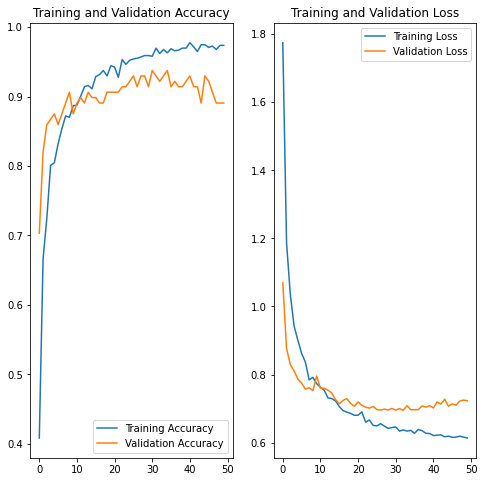

In [ ]:
# Check history
histModel = model
epochs = EPOCHS
history = model.history.history
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Export & evaluate tflite
model.export(export_dir='.', label_filename='labels.txt', export_format=ExportFormat.LABEL)
model.export(export_dir='.', tflite_filename='mobilenetModel.tflite', export_format=ExportFormat.TFLITE)
model.evaluate_tflite('mobilenetModel.tflite', test_data)

In [ ]:
# Export to saved model
model.export(export_dir='.', export_format=ExportFormat.SAVED_MODEL)

In [ ]:
savedModel = tf.saved_model.load('saved_model')
class_names=['maryam','nawaz','shahbaz']


In [ ]:
lbl_map = np.array(class_names)
print(lbl_map)

['maryam' 'nawaz' 'shahbaz']


In [ ]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

In [ ]:
# Predict ALL
import glob
useModel=model
class_names=['maryam','nawaz','shahbaz']
for label in class_names:
  print("Scanning: " + label)
  paths = glob.glob("image-data/" + label + "/*")
  for filePath in paths:
    img = tf.keras.preprocessing.image.load_img(filePath, target_size=[224, 224])
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = tf.keras.applications.mobilenet.preprocess_input(x[tf.newaxis,...])
    print('Prediction for ' + filePath)
    print(useModel.model.predict(tf.constant(x)))
